# Learning Objectives

Towards the end of this lesson, you should be able to:
- experiments with 2 different feature selection algorithms
- define different ways to evaluate a model


### Load Libraries

In [1]:
from sklearn.ensemble import RandomForestClassifier
from boruta import BorutaPy
from sklearn.feature_selection import RFECV
from sklearn.model_selection import train_test_split

import numpy as np
import pandas as pd

from matplotlib import pyplot as plt
import seaborn as sns

from sklearn.preprocessing import MinMaxScaler

from sklearn.tree import DecisionTreeClassifier 
from sklearn.naive_bayes import GaussianNB

from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
from sklearn.metrics import precision_recall_curve

from tqdm import tqdm 

import warnings
warnings.filterwarnings('ignore')

pd.set_option("display.max_columns", 500)

# Feature Selection

### Function for Ranking Feature

This is a function to do the ranking of the variables

In [2]:
# do the transformation to make it into rank the features and the score

def ranking(ranks, names, order=1):
    minmax = MinMaxScaler()
    ranks = minmax.fit_transform(order*np.array([ranks]).T).T[0]
    ranks = map(lambda x: round(x,2), ranks)
    return dict(zip(names, ranks))

### Read Dataset

In [3]:
df = pd.read_csv("banking.csv")
df.head()

,age,job,marital,education,default,housing,loan,contact,month,day_of_week,duration,campaign,pdays,previous,poutcome,emp_var_rate,cons_price_idx,cons_conf_idx,euribor3m,nr_employed,y
0,44,blue-collar,married,basic.4y,unknown,yes,no,cellular,aug,thu,210,1,999,0,nonexistent,1.4,93.444,-36.1,4.963,5228.1,0
1,53,technician,married,unknown,no,no,no,cellular,nov,fri,138,1,999,0,nonexistent,-0.1,93.200,-42.0,4.021,5195.8,0
2,28,management,single,university.degree,no,yes,no,cellular,jun,thu,339,3,6,2,success,-1.7,94.055,-39.8,0.729,4991.6,1
3,39,services,married,high.school,no,no,no,cellular,apr,fri,185,2,999,0,nonexistent,-1.8,93.075,-47.1,1.405,5099.1,0
4,55,retired,married,basic.4y,no,yes,no,cellular,aug,fri,137,1,3,1,success,-2.9,92.201,-31.4,0.869,5076.2,1


In [4]:
df.y.value_counts()

0    36548
1     4640
Name: y, dtype: int64

### One-Hot Encoding

In [5]:
col_list = [col for col in df.columns.tolist() if
           df[col].dtype.name == "object"]
df_oh = df[col_list]
df = df.drop(col_list, 1)
df_oh = pd.get_dummies(df_oh)
df = pd.concat([df,df_oh], axis = 1)
df.head()

,age,duration,campaign,pdays,previous,emp_var_rate,cons_price_idx,cons_conf_idx,euribor3m,nr_employed,y,job_admin.,job_blue-collar,job_entrepreneur,job_housemaid,job_management,job_retired,job_self-employed,job_services,job_student,job_technician,job_unemployed,job_unknown,marital_divorced,marital_married,marital_single,marital_unknown,education_basic.4y,education_basic.6y,education_basic.9y,education_high.school,education_illiterate,education_professional.course,education_university.degree,education_unknown,default_no,default_unknown,default_yes,housing_no,housing_unknown,housing_yes,loan_no,loan_unknown,loan_yes,contact_cellular,contact_telephone,month_apr,month_aug,month_dec,month_jul,month_jun,month_mar,month_may,month_nov,month_oct,month_sep,day_of_week_fri,day_of_week_mon,day_of_week_thu,day_of_week_tue,day_of_week_wed,poutcome_failure,poutcome_nonexistent,poutcome_success
0,44,210,1,999,0,1.4,93.444,-36.1,4.963,5228.1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,1,1,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0
1,53,138,1,999,0,-0.1,93.200,-42.0,4.021,5195.8,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,1,1,0,0,1,0,0,1,0,0,1,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,1,0
2,28,339,3,6,2,-1.7,94.055,-39.8,0.729,4991.6,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,1,0,0,0,0,1,1,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,1
3,39,185,2,999,0,-1.8,93.075,-47.1,1.405,5099.1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,1,0,0,1,0,0,1,0,0,1,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0
4,55,137,1,3,1,-2.9,92.201,-31.4,0.869,5076.2,1,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,1,1,0,0,1,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1


### Separate into X, y

In [6]:
y = df.y
X = df.drop("y", 1)
colnames = X.columns

### Prepare Boruta classifier

In [7]:
# using the BorutaPy function
rf = RandomForestClassifier(n_jobs = -1,
                           class_weight = "balanced_subsample",
                           max_depth = 5)
feat_selector = BorutaPy(rf, n_estimators = "auto", random_state = 1)

### Fit Boruta classifier to data

In [9]:
feat_selector.fit(X.values, y.values.ravel())

BorutaPy(estimator=RandomForestClassifier(class_weight='balanced_subsample',
                                          max_depth=5, n_estimators=146,
                                          n_jobs=-1,
                                          random_state=RandomState(MT19937) at 0x28E5121FA40),
         n_estimators='auto',
         random_state=RandomState(MT19937) at 0x28E5121FA40)

### Get the ranking of the features returned by Boruta

In [10]:
# ranking function return a dictionary (variables and scores that have been normalized)
boruta_score = ranking(list(map(float, feat_selector.ranking_)), colnames, order=-1)

# transform them into dataframe
boruta_score = pd.DataFrame(list(boruta_score.items()), columns=['Features', 'Score'])

# sort them into scores
boruta_score = boruta_score.sort_values("Score", ascending = False)

### Top and Bottom 10 features


In [11]:
print('---------Top 10----------')
display(boruta_score.head(10))

# 1.0 = equivalently important towards y, whether they should subscribe to the promotional items

print('---------Bottom 10----------')
boruta_score.tail(10)

---------Top 10----------


,Features,Score
0,age,1.0
18,job_student,1.0
61,poutcome_nonexistent,1.0
60,poutcome_failure,1.0
54,month_sep,1.0
53,month_oct,1.0
51,month_may,1.0
50,month_mar,1.0
49,month_jun,1.0
45,month_apr,1.0


---------Bottom 10----------


,Features,Score
41,loan_unknown,0.25
21,job_unknown,0.25
20,job_unemployed,0.19
42,loan_yes,0.14
38,housing_unknown,0.14
31,education_professional.course,0.14
14,job_management,0.08
25,marital_unknown,0.06
30,education_illiterate,0.03
36,default_yes,0.00


### Plot it out

Text(0.5, 1.0, 'Boruta all Features')

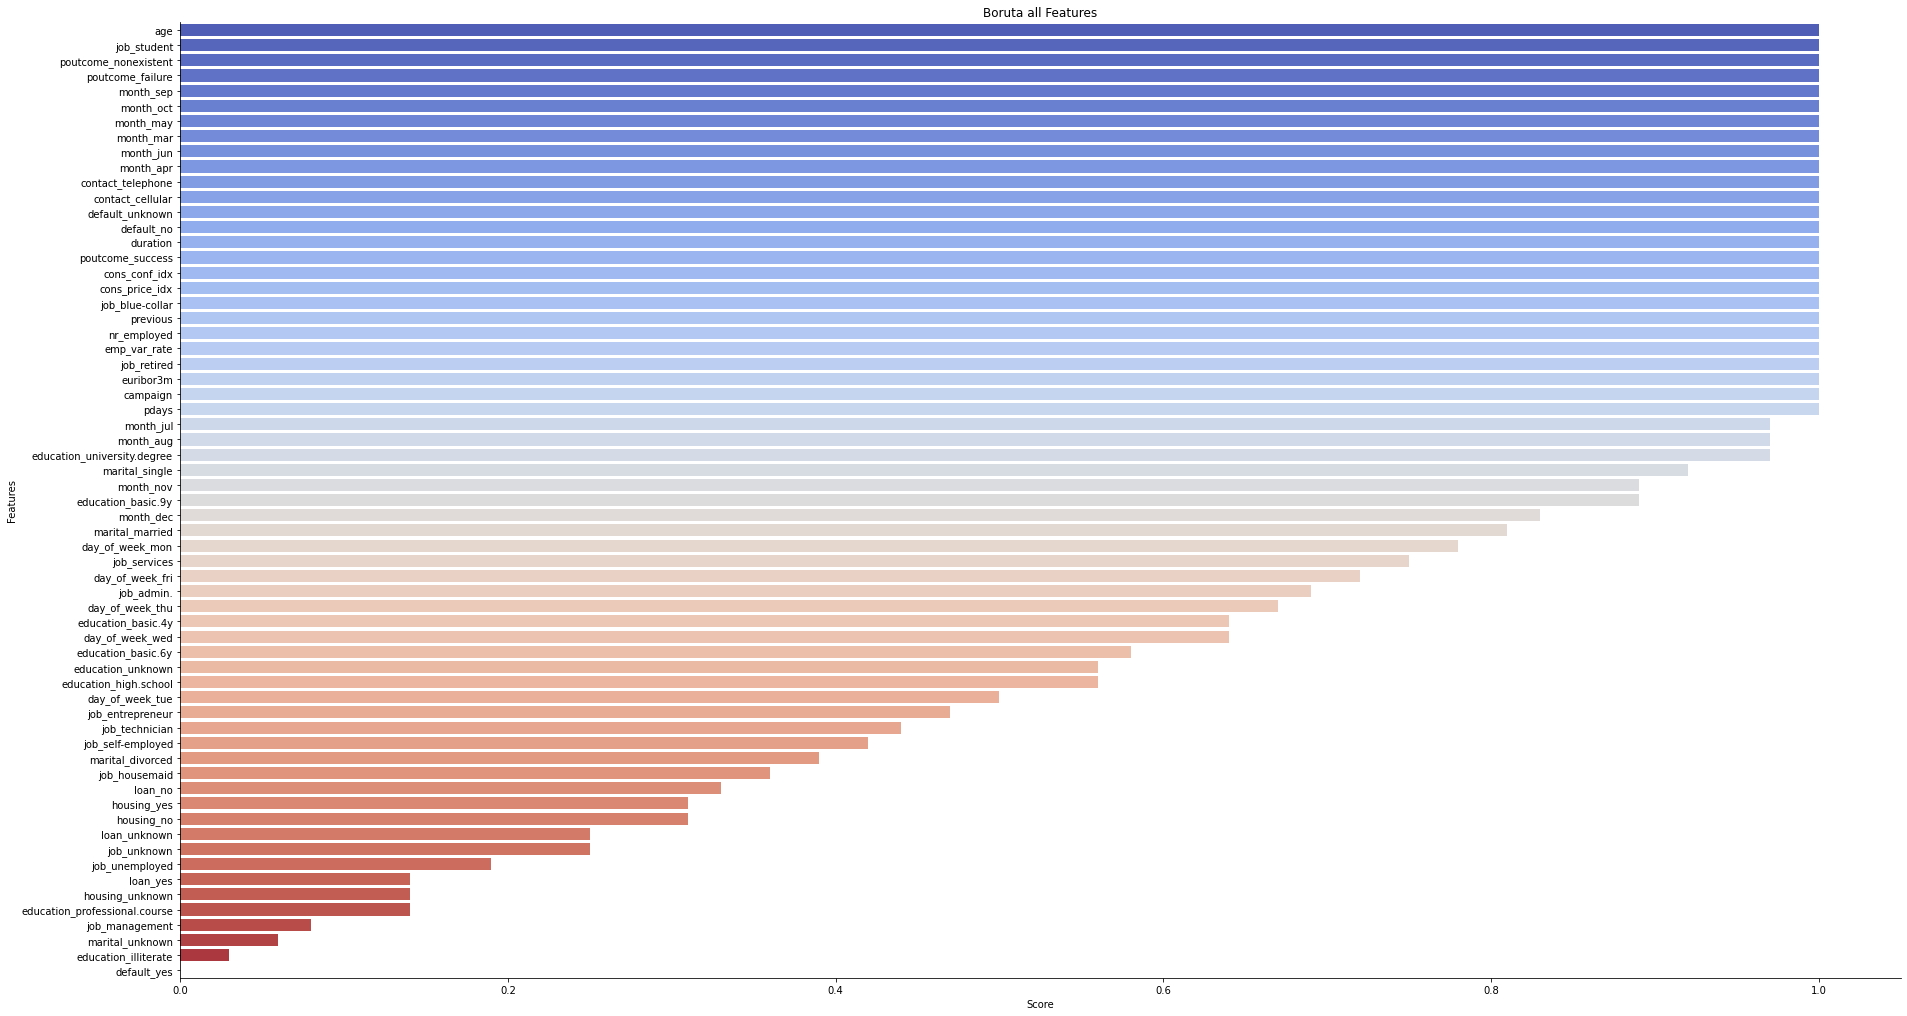

In [12]:
# it is important for decision-making

sns_boruta_plot = sns.catplot(x="Score", y="Features", data = boruta_score[:], kind = "bar", 
               height=14, aspect=1.9, palette='coolwarm')
plt.title("Boruta all Features")

## RFE

### Prepare RFE classifier

In [13]:
# Task:
# Try the following params:
# 1. class_weight={0:1,1:2}
# 2. class_weight="balanced"
# 3. max_depth=4
# 4. max_depth=6
# 5. n_estimators = 100
# observe the feature importance ranking.

rf = RandomForestClassifier(n_jobs = -1,
                           class_weight = "balanced_subsample",
                           max_depth = 5,
                           n_estimators = 100)
rf.fit(X,y)
rfe = RFECV(rf, min_features_to_select = 1, cv = 3)

### Fit RFE classifier to data

In [14]:
rfe.fit(X, y)

RFECV(cv=3,
      estimator=RandomForestClassifier(class_weight='balanced_subsample',
                                       max_depth=5, n_jobs=-1))

### Get the ranking of the features returned by RFE

In [15]:
rfe_score = ranking(list(map(float, rfe.ranking_)), colnames, order=-1)
rfe_score = pd.DataFrame(list(rfe_score.items()), columns=['Features', 'Score'])
rfe_score = rfe_score.sort_values("Score", ascending = False)

### Plot it out

Text(0.5, 1.0, 'RFE bottom-10 Features')

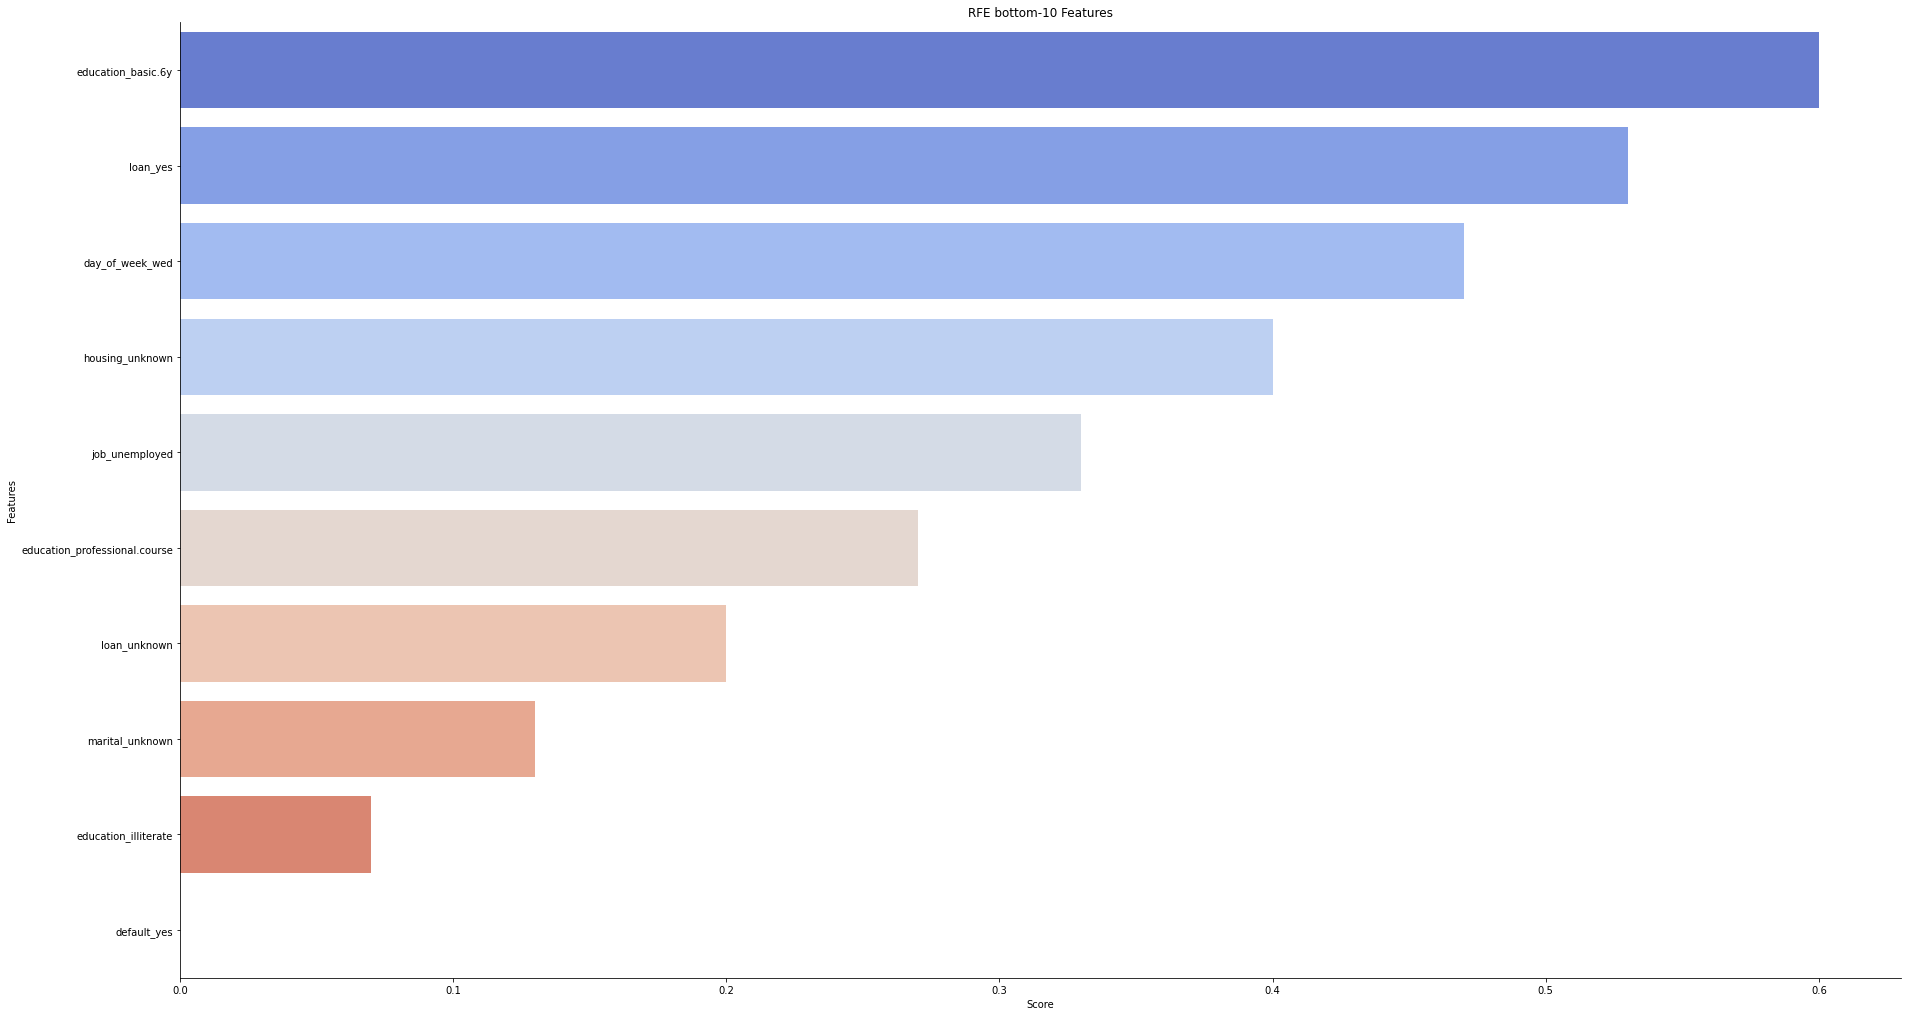

In [16]:
sns_rfe_plot = sns.catplot(x="Score", y="Features", data = rfe_score[-10:], kind = "bar", 
               height=14, aspect=1.9, palette='coolwarm')
plt.title("RFE bottom-10 Features")

# Modeling

In [17]:
# Setup model list using only NB and DT
# goal: to know which one is a better version side-by-side comparison

model_list = ["NB", "DT"]
feature_num, acc_nb, acc_dt = [], [], []

for i in range(1, 30):
    feature_num.append(i)
    for model in model_list:
        
        # Create X and y dataset
        y = df.y
        X = df.drop("y", axis = 1)
        
        cols = boruta_score.Features[0:i]
        X = X[cols].copy()
        
        # Split data
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3)
        
        if model == "NB":
            clf = GaussianNB()
        elif model == "DT":
            clf = DecisionTreeClassifier(max_depth=3) 
        
        clf.fit(X_train, y_train)
        y_pred = clf.predict(X_test)
        
        acc = round((accuracy_score(y_test, y_pred)*100), 2)
        
        if model == "NB":
            acc_nb.append(acc)
        elif model == "DT":
            acc_dt.append(acc) 
            
boruta_acc_result = pd.DataFrame(list(zip(feature_num,
                                        acc_nb,
                                        acc_dt)),
                               columns = ["No_Of_Features",
                                         "NB",
                                         "DT"])

print(boruta_acc_result['NB'].mean())
print(boruta_acc_result['DT'].mean())

boruta_acc_result = pd.melt(boruta_acc_result,
                           id_vars = "No_Of_Features",
                           var_name = "Model",
                           value_name = "Accuracy")


86.71586206896552
90.10448275862068


[Text(0.5, 1.0, 'Accuracy Trend for Different Classifiers (Boruta)')]

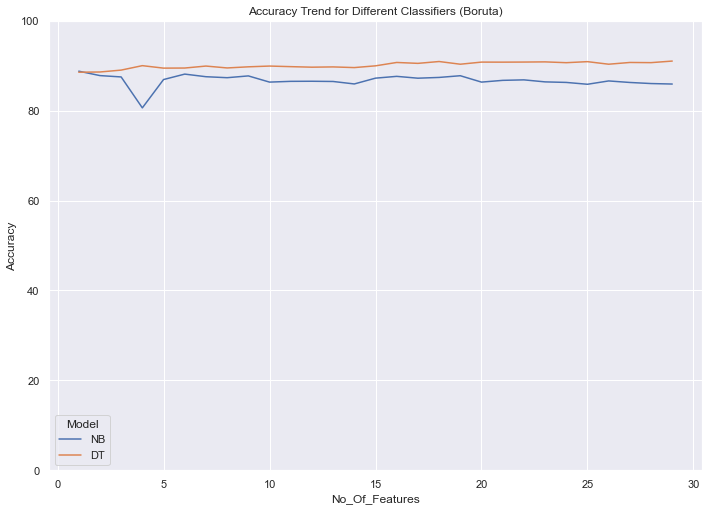

In [18]:
# Plot the line charts

sns.set(rc={'figure.figsize':(11.7,8.27)})

ax = sns.lineplot(x = "No_Of_Features", y = "Accuracy", hue = "Model", data = boruta_acc_result)
ax.set(ylim=(0, 100))
ax.set(title="Accuracy Trend for Different Classifiers (Boruta)")

In [20]:
# Get the model accuracy using different number of features

boruta_acc_result

,No_Of_Features,Model,Accuracy
0,1,NB,88.78
1,2,NB,87.80
2,3,NB,87.50
3,4,NB,80.62
4,5,NB,86.92
5,6,NB,88.13
6,7,NB,87.55
7,8,NB,87.33
8,9,NB,87.73
9,10,NB,86.35


# Model Evaluation

In [21]:
# Read dataset

df = pd.read_csv('banking.csv') 
df.head()

,age,job,marital,education,default,housing,loan,contact,month,day_of_week,duration,campaign,pdays,previous,poutcome,emp_var_rate,cons_price_idx,cons_conf_idx,euribor3m,nr_employed,y
0,44,blue-collar,married,basic.4y,unknown,yes,no,cellular,aug,thu,210,1,999,0,nonexistent,1.4,93.444,-36.1,4.963,5228.1,0
1,53,technician,married,unknown,no,no,no,cellular,nov,fri,138,1,999,0,nonexistent,-0.1,93.200,-42.0,4.021,5195.8,0
2,28,management,single,university.degree,no,yes,no,cellular,jun,thu,339,3,6,2,success,-1.7,94.055,-39.8,0.729,4991.6,1
3,39,services,married,high.school,no,no,no,cellular,apr,fri,185,2,999,0,nonexistent,-1.8,93.075,-47.1,1.405,5099.1,0
4,55,retired,married,basic.4y,no,yes,no,cellular,aug,fri,137,1,3,1,success,-2.9,92.201,-31.4,0.869,5076.2,1


In [22]:
# Prepare X and y

df_X = df.drop('y', axis=1)
y = df['y']

In [23]:
# dummification of variables

X = pd.get_dummies(df_X, drop_first = True)

In [24]:
X.columns

Index(['age', 'duration', 'campaign', 'pdays', 'previous', 'emp_var_rate',
       'cons_price_idx', 'cons_conf_idx', 'euribor3m', 'nr_employed',
       'job_blue-collar', 'job_entrepreneur', 'job_housemaid',
       'job_management', 'job_retired', 'job_self-employed', 'job_services',
       'job_student', 'job_technician', 'job_unemployed', 'job_unknown',
       'marital_married', 'marital_single', 'marital_unknown',
       'education_basic.6y', 'education_basic.9y', 'education_high.school',
       'education_illiterate', 'education_professional.course',
       'education_university.degree', 'education_unknown', 'default_unknown',
       'default_yes', 'housing_unknown', 'housing_yes', 'loan_unknown',
       'loan_yes', 'contact_telephone', 'month_aug', 'month_dec', 'month_jul',
       'month_jun', 'month_mar', 'month_may', 'month_nov', 'month_oct',
       'month_sep', 'day_of_week_mon', 'day_of_week_thu', 'day_of_week_tue',
       'day_of_week_wed', 'poutcome_nonexistent', 'poutcome_s

In [25]:
X.head()

,age,duration,campaign,pdays,previous,emp_var_rate,cons_price_idx,cons_conf_idx,euribor3m,nr_employed,job_blue-collar,job_entrepreneur,job_housemaid,job_management,job_retired,job_self-employed,job_services,job_student,job_technician,job_unemployed,job_unknown,marital_married,marital_single,marital_unknown,education_basic.6y,education_basic.9y,education_high.school,education_illiterate,education_professional.course,education_university.degree,education_unknown,default_unknown,default_yes,housing_unknown,housing_yes,loan_unknown,loan_yes,contact_telephone,month_aug,month_dec,month_jul,month_jun,month_mar,month_may,month_nov,month_oct,month_sep,day_of_week_mon,day_of_week_thu,day_of_week_tue,day_of_week_wed,poutcome_nonexistent,poutcome_success
0,44,210,1,999,0,1.4,93.444,-36.1,4.963,5228.1,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,1,0
1,53,138,1,999,0,-0.1,93.200,-42.0,4.021,5195.8,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0
2,28,339,3,6,2,-1.7,94.055,-39.8,0.729,4991.6,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,1
3,39,185,2,999,0,-1.8,93.075,-47.1,1.405,5099.1,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0
4,55,137,1,3,1,-2.9,92.201,-31.4,0.869,5076.2,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1


In [26]:
# Prepare the train and test dataset

X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                    test_size=0.2,
                                                    random_state=7)

### Training a Decision Tree Model


In [27]:
# construct Decision Tree Model

model_DT = DecisionTreeClassifier(max_depth=3)
model_DT.fit(X_train, y_train)

y_pred = model_DT.predict(X_test)

In [28]:
y_pred

array([0, 0, 0, ..., 0, 0, 0], dtype=int64)

In [1]:
# Model Accuracy

# this dataset is very good, it's performing at 90%

print("Accuracy on training set: {:.3f}".format(model_DT.score(X_train,y_train)))
print("Accuracy on test set: {:.3f}".format(model_DT.score(X_test, y_test)))

NameError: name 'model_DT' is not defined

In [30]:
# Confusion matrix report

confusion_majority=confusion_matrix(y_test, y_pred)

print('Mjority classifier Confusion Matrix\n', confusion_majority)

print('**********************')
print('Mjority TN= ', confusion_majority[0][0])
print('Mjority FP=', confusion_majority[0][1])
print('Mjority FN= ', confusion_majority[1][0])
print('Mjority TP= ', confusion_majority[1][1])
print('**********************')

print('Precision= {:.2f}'.format(precision_score(y_test, y_pred)))
print('Recall= {:.2f}'. format(recall_score(y_test, y_pred)))
print('F1= {:.2f}'. format(f1_score(y_test, y_pred)))
print('Accuracy= {:.2f}'. format(accuracy_score(y_test, y_pred)))

# look at F1 score first, then the accuracy. if it is less than 50%, it might be wrong

Mjority classifier Confusion Matrix
 [[6980  341]
 [ 392  525]]
**********************
Mjority TN=  6980
Mjority FP= 341
Mjority FN=  392
Mjority TP=  525
**********************
Precision= 0.61
Recall= 0.57
F1= 0.59
Accuracy= 0.91


In [37]:
# Calculate AUC

prob_DT = model_DT.predict_proba(X_test)
prob_DT = prob_DT[:, 1]

auc_DT = roc_auc_score(y_test, prob_DT)
print('AUC: %.2f' % auc_DT)

AUC: 0.90


In [32]:
prob_DT = model_DT.predict(X_test)
prob_DT

array([0, 0, 0, ..., 0, 0, 0], dtype=int64)

In [33]:
prob_DT = model_DT.predict_proba(X_test)
prob_DT

array([[0.98394306, 0.01605694],
       [0.98394306, 0.01605694],
       [0.98394306, 0.01605694],
       ...,
       [0.98394306, 0.01605694],
       [0.98394306, 0.01605694],
       [0.98394306, 0.01605694]])

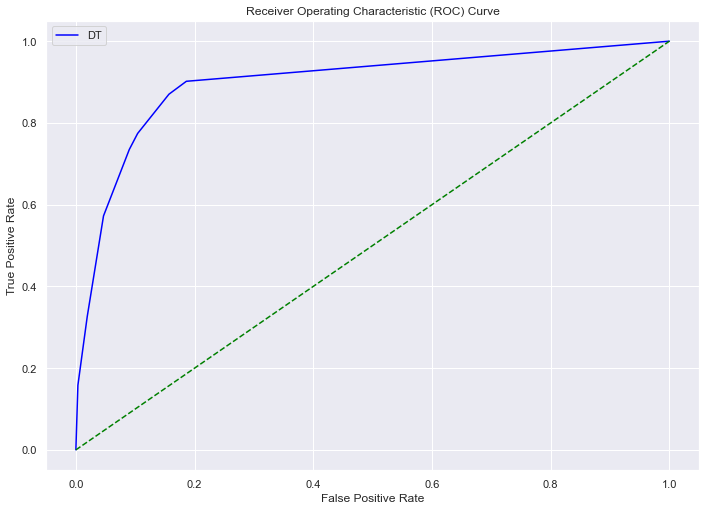

In [38]:
# Plot ROC Curve 

fpr_DT, tpr_DT, thresholds_DT = roc_curve(y_test, prob_DT)

plt.plot(fpr_DT, tpr_DT, color='blue', label='DT') 
plt.plot([0, 1], [0, 1], color='green', linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend()

# the higher it goes, almost parallel to the y-axis, the better it is

0.6229378271636494


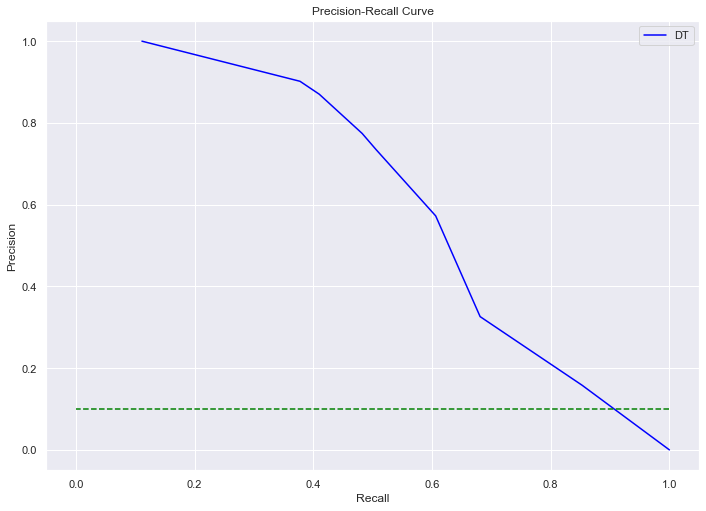

In [39]:
# Plot Precision-Recall Curve
from sklearn import metrics

prec_DT, rec_DT, threshold_DT = precision_recall_curve(y_test, prob_DT)

plt.plot(prec_DT, rec_DT, color='blue', label='DT') 
plt.plot([1, 0], [0.1, 0.1], color='green', linestyle='--')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend()

 
# calculate precision-recall AUC 
print(metrics.auc(rec_DT, prec_DT))

# precision go to the right

### Training a Naive Bayes Model

In [40]:
nb = GaussianNB()
nb.fit(X_train, y_train)
y_pred = nb.predict(X_test)

In [41]:
# Model Accuracy

print("Accuracy on training set: {:.3f}".format(nb.score(X_train, y_train)))
print("Accuracy on test set: {:.3f}".format(nb.score(X_test, y_test)))

Accuracy on training set: 0.873
Accuracy on test set: 0.873


In [42]:
confusion_majority=confusion_matrix(y_test, y_pred)

print('Mjority classifier Confusion Matrix\n', confusion_majority)

print('**********************')
print('Mjority TN= ', confusion_majority[0][0])
print('Mjority FP=', confusion_majority[0][1])
print('Mjority FN= ', confusion_majority[1][0])
print('Mjority TP= ', confusion_majority[1][1])
print('**********************')

print('Precision= {:.2f}'.format(precision_score(y_test, y_pred)))
print('Recall= {:.2f}'. format(recall_score(y_test, y_pred)))
print('F1= {:.2f}'. format(f1_score(y_test, y_pred)))
print('Accuracy= {:.2f}'. format(accuracy_score(y_test, y_pred)))

Mjority classifier Confusion Matrix
 [[6750  571]
 [ 479  438]]
**********************
Mjority TN=  6750
Mjority FP= 571
Mjority FN=  479
Mjority TP=  438
**********************
Precision= 0.43
Recall= 0.48
F1= 0.45
Accuracy= 0.87


In [43]:
# Calculate AUC

prob_NB = nb.predict_proba(X_test)
prob_NB = prob_NB[:, 1]

auc_NB = roc_auc_score(y_test, prob_NB)
print('AUC: %.2f' % auc_NB)

AUC: 0.84


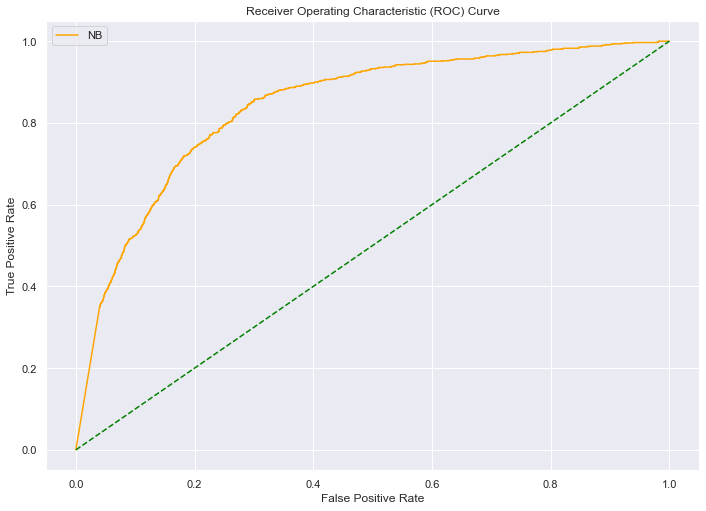

In [44]:
# Plot ROC Curve 

fpr_NB, tpr_NB, thresholds_NB = roc_curve(y_test, prob_NB) 

plt.plot(fpr_NB, tpr_NB, color='orange', label='NB') 
plt.plot([0, 1], [0, 1], color='green', linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend()


0.48273103742794954


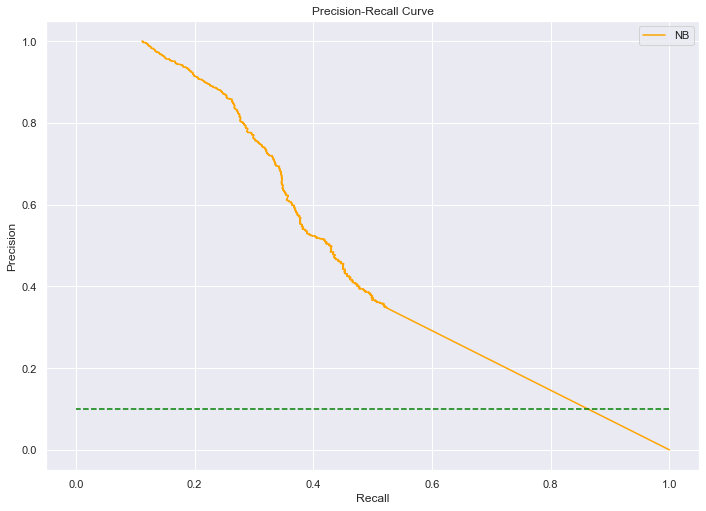

In [45]:
prec_NB, rec_NB, threshold_NB = precision_recall_curve(y_test, prob_NB)

plt.plot(prec_NB, rec_NB, color='orange', label='NB') 
plt.plot([1, 0], [0.1, 0.1], color='green', linestyle='--')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend()

# calculate precision-recall AUC 
print(metrics.auc(rec_NB, prec_NB))

### Performance Comparison

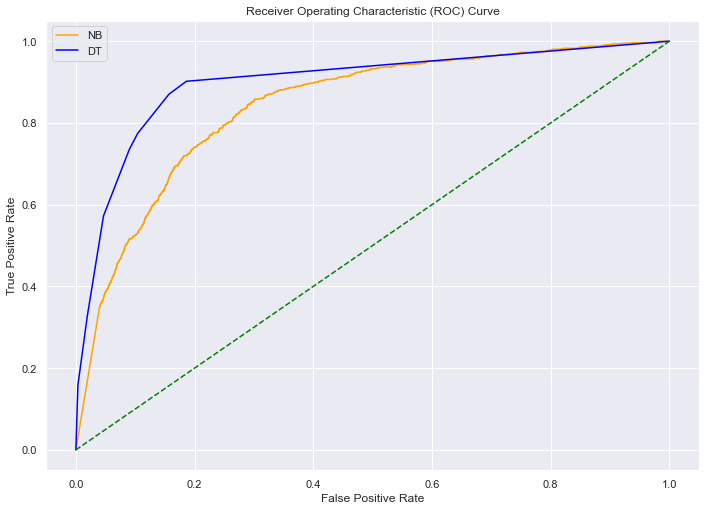

In [46]:
plt.plot(fpr_NB, tpr_NB, color='orange', label='NB') 
plt.plot(fpr_DT, tpr_DT, color='blue', label='DT')  
plt.plot([0, 1], [0, 1], color='green', linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend()

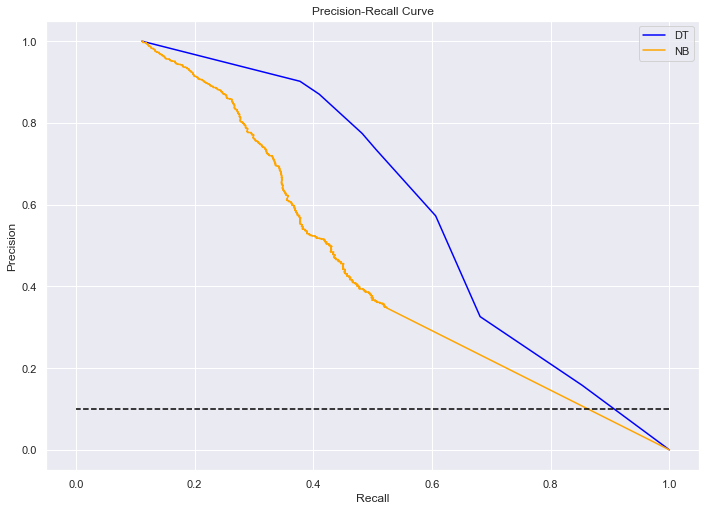

In [47]:

plt.plot(prec_DT, rec_DT, color='blue', label='DT') 
plt.plot(prec_NB, rec_NB, color='orange', label='NB') 

plt.plot([1, 0], [0.1, 0.1], color='black', linestyle='--')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend()